# **Police Deaths in the USA**
## EDA - Exploratory Data Analysis

**Description:** This is a work in progress data exploration of the Police Death dataset available here:
https://github.com/fivethirtyeight/data/tree/master/police-deaths 

## **Imports and set up**

In [37]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams

import os
import shutil
import time

import folium
import imageio
import webbrowser
import zipfile
import json
import fileinput

from os import path
from branca.colormap import linear
from selenium import webdriver
from PIL import Image
from pathlib import Path


In [38]:
data = pd.read_csv('police_deaths.csv', skipinitialspace=True)
data.to_csv('out.csv')

data.head()


,person,dept,eow,cause,cause_short,date,year,canine,dept_name,state
0,Constable Darius Quimby,"Albany County Constable's Office, NY","EOW: Monday, January 3, 1791",Cause of Death: Gunfire,Gunfire,1791-01-03,1791,False,Albany County Constable's Office,NY
1,Sheriff Cornelius Hogeboom,"Columbia County Sheriff's Office, NY","EOW: Saturday, October 22, 1791",Cause of Death: Gunfire,Gunfire,1791-10-22,1791,False,Columbia County Sheriff's Office,NY
2,Deputy Sheriff Isaac Smith,"Westchester County Sheriff's Department, NY","EOW: Thursday, May 17, 1792",Cause of Death: Gunfire,Gunfire,1792-05-17,1792,False,Westchester County Sheriff's Department,NY
3,Marshal Robert Forsyth,United States Department of Justice - United S...,"EOW: Saturday, January 11, 1794",Cause of Death: Gunfire,Gunfire,1794-01-11,1794,False,United States Department of Justice - United S...,US
4,Sheriff Robert Maxwell,"Greenville County Sheriff's Office, SC","EOW: Sunday, November 12, 1797",Cause of Death: Gunfire,Gunfire,1797-11-12,1797,False,Greenville County Sheriff's Office,SC


## **Intial Data Prep**

In [39]:
# Dropping unnecessary columns

data = data.drop(['eow','cause'], axis=1)

# Change date to date data type:

data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')

data['weekday'] = data['date'].dt.strftime('%A')
data['month'] = data['date'].dt.strftime('%B')

#data.append(['weekday', 'month'], ignore_index=True)

data.head()

,person,dept,cause_short,date,year,canine,dept_name,state,weekday,month
0,Constable Darius Quimby,"Albany County Constable's Office, NY",Gunfire,1791-01-03,1791,False,Albany County Constable's Office,NY,Monday,January
1,Sheriff Cornelius Hogeboom,"Columbia County Sheriff's Office, NY",Gunfire,1791-10-22,1791,False,Columbia County Sheriff's Office,NY,Saturday,October
2,Deputy Sheriff Isaac Smith,"Westchester County Sheriff's Department, NY",Gunfire,1792-05-17,1792,False,Westchester County Sheriff's Department,NY,Thursday,May
3,Marshal Robert Forsyth,United States Department of Justice - United S...,Gunfire,1794-01-11,1794,False,United States Department of Justice - United S...,US,Saturday,January
4,Sheriff Robert Maxwell,"Greenville County Sheriff's Office, SC",Gunfire,1797-11-12,1797,False,Greenville County Sheriff's Office,SC,Sunday,November


 **Splitting Data between Police Officer Deaths and K9 Unit Deaths**

In [40]:
#Seperate Police Officer deaths from K9 Units

police_deaths = data.loc[data.canine == False]
k9_deaths = data.loc[data.canine == True]

np.size(police_deaths)

225370

## **Exploration 1:**
### Most common cause of death


Change in cause over time - do gun deaths iincrease at an increasing rate?

In [41]:
police_cod = police_deaths[['cause_short', 'person']]
police_cod_grouped = police_cod.groupby('cause_short').count()
police_cod_grouped['Percentage of Total'] = police_cod_grouped.person /  police_cod_grouped.person.sum()
police_cod_grouped.reset_index(level=0, inplace=True)
police_cod_grouped.sort_values(by='person', ascending=False, inplace=True)

police_cod_grouped.head()

,cause_short,person,Percentage of Total
17,Gunfire,11985,0.531792
5,Automobile accident,2335,0.103607
21,Motorcycle accident,1134,0.050317
19,Heart attack,977,0.043351
33,Vehicular assault,882,0.039136


Text(0, 0.5, 'Number of Deaths')

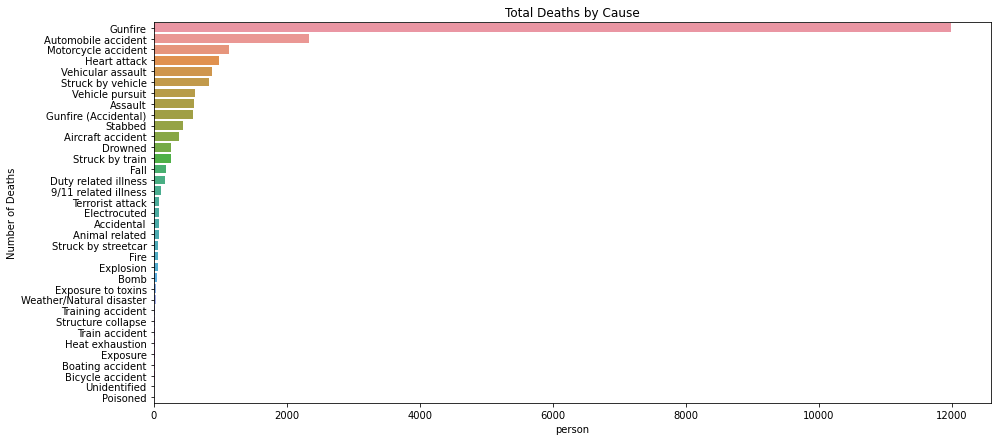

In [42]:
plt.figure(figsize=(15,7))

# Add title
plt.title('Total Deaths by Cause')

# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(y=police_cod_grouped['cause_short'], x=police_cod_grouped['person'])

# Add label for vertical axis
plt.ylabel('Number of Deaths')

**Gunfire is by far the most often cause of death in this dataset, making up 53% of entire deaths.**

## **Exploration 2:**
### Most common area
*BUG* - WIP need to fix matching betweeen JSON state codes and csv

In [43]:
police_st = police_deaths[['state', 'person']]

#These states were not available in my GeoJSON file so I decided to exclude these for now since folium Choropleth needs matched values. 
excluded_states = ['AS', 'CZ', 'GU', 'MP', 'PR', 'RR', 'TR', 'US', 'VI', 'DC']

for x in excluded_states:
    police_st = police_st[~police_st['state'].str.contains(x)]

police_st_grouped = police_st.groupby('state').count()
police_st_grouped.reset_index(level=0, inplace=True)
police_st_grouped['state'] = police_st_grouped['state'].astype(str)

#police_st_grouped.sort_values(by='person', ascending=False, inplace=True)

#police_st_grouped

In [45]:
police_st_grouped.dtypes

state     object
person     int64
dtype: object

In [53]:

m = folium.Map(location=[40, -95], zoom_start=4, tiles='OpenStreetMap')

state_geo = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json'
#return requests.get(state_geo).json()

folium.Choropleth(
    geo_data= state_geo,
    name='choropleth',
    data=police_st_grouped,
    columns=['state', 'person'],
    key_on="feature.id",
    fill_color='BuPu',
    fill_opacity=0.5,
    line_opacity=.1,
    legend_name='Number of Officer Deaths per State',
    bins=9
).add_to(m)

folium.LayerControl().add_to(m)

m


Whilst the above is useful to observe the total deaths from the begining of the dataset (1791), it doesn't tell us anything about trends over time.

Choropleth maps can be very useful visualisations, however in some cases it can be misleading: 
https://www.reddit.com/r/dataisbeautiful/comments/knfbvp/oc_dont_trust_a_choropleth_mapevidence_from/

Since our data is not as granular (staying only on the state level), or determining aggregates like the voting example above, this use case is appropriate in this context.

## **Exploration 3:**
### Time Series Analysis

In [ ]:
# check date column type

police_deaths['date'].dtype

dtype('<M8[ns]')

In [ ]:
df = police_deaths.loc[~(police_deaths['year'] <= 1800)]

In [ ]:
# Deaths per Day
df2 = df[['date', 'person']]
df2 = df2.groupby('date').count()
df2.reset_index(level=0, inplace=True)

# Extract and groupby Year 
df3 = df2.groupby(df['date'].dt.strftime('%Y'))['person'].sum().sort_values()
df3 = df3.to_frame()
df3.reset_index(level=0, inplace=True)
df3.sort_values(by='date', ascending=True, inplace=True)


In [ ]:
# Above created a series when extracting Year from date, so now need to convert back into a dataframe

df3['date'] = pd.to_datetime(df3['date'])
df3['date'].dtype

dtype('<M8[ns]')

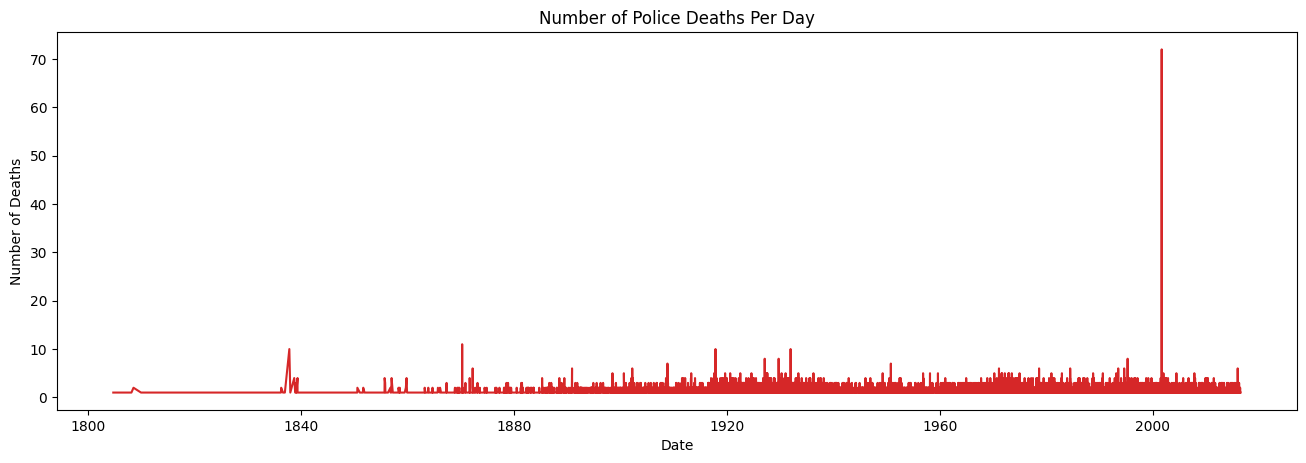

In [ ]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Number of Deaths', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df2, x=df2.date, y=df2.person, title='Number of Police Deaths Per Day')  

**There is a large spike in deaths per day near year 2000. Let's investigate further...**

In [ ]:
df2.loc[(df2['person'] > 60)]

,date,person
15196,2001-09-11,72


**Date returned is the 9/11 Terror attacks.**

**After some googling, was able to find the list of names of the officers who died:**
https://nleomf.org/memorial/fallen-heroes/remembering-9-11/

**They also have 72 total for that day.**

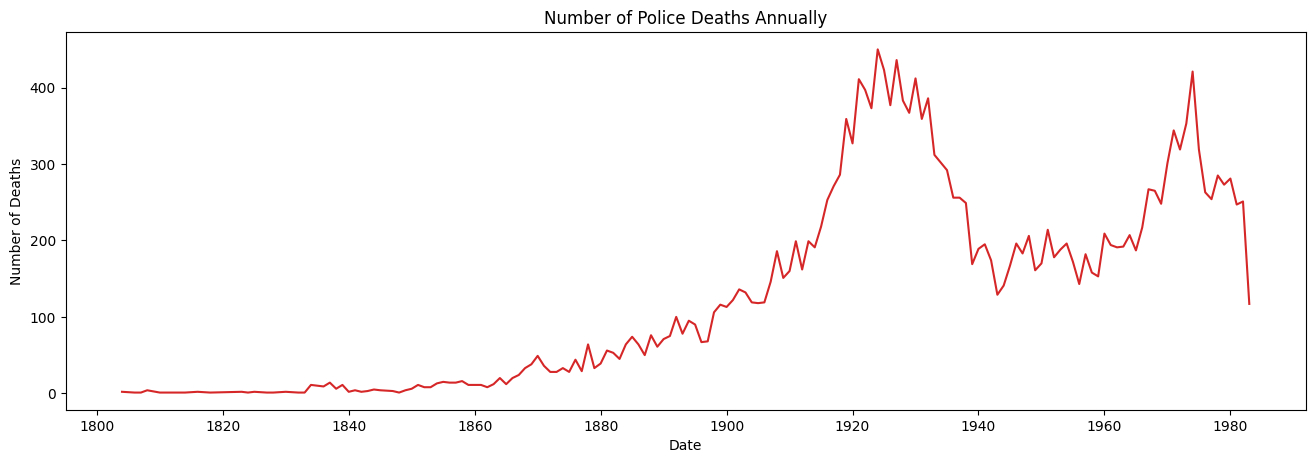

In [ ]:
plot_df(df3, x=df3.date, y=df3.person, title='Number of Police Deaths Annually')

**Police deaths seemed to have peaked between 1920s and 1930s. Major events around this time were the World Wars. The deaths picked up again around 1970 too. No major event comes to mind, but perhaps this may be gang related?**

TO DO : Further analysis on popular cause of deaths around these times.


In [ ]:
df4 = df[['year', 'person', 'cause_short']]
df4 = df4.groupby(['year', 'cause_short']).count().reset_index()
df4.set_index('year', inplace=True)


In [ ]:
# Pivot

df4_pivoted = df4.pivot(columns='cause_short', values='person')
#df4_pivoted.head()

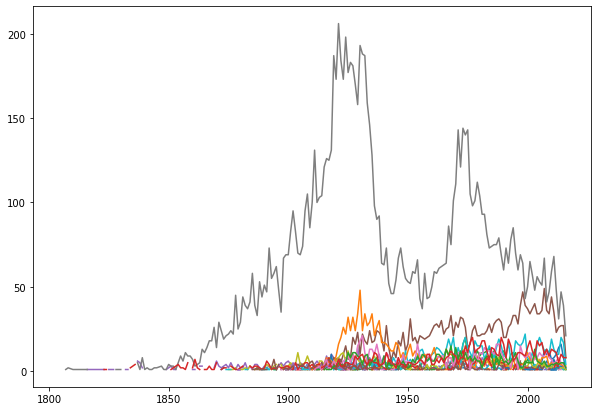

In [ ]:
rcParams['figure.figsize'] = 10,7
plt.plot(df4_pivoted)
plt.show()

**Looks a bit messy, so will filter to show top 5 categories from the 1st exploration**

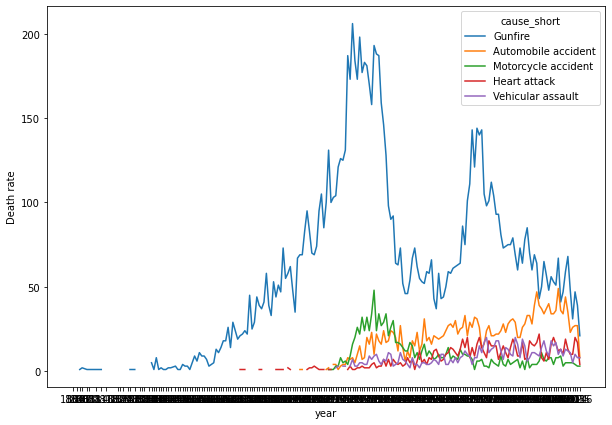

In [ ]:
df4_filtered = df4_pivoted[['Gunfire', 'Automobile accident', 'Motorcycle accident', 'Heart attack', 'Vehicular assault']]

rcParams['figure.figsize'] = 10,7
ax = df4_filtered.plot(xticks=df4_filtered.index)
ylab = ax.set_ylabel('Death rate')

#plt.plot(df4_filtered)
#plt.legend()

**Interestingly, although Gunfire is the most often cause of death, it has been declining rapidly after the peak in 1960s.**

**Automobile deaths however are on the rise.**

*BUG: Fix x-axis. This is due to year not set as datetime I believe*

## **Exploration 4:** 
### Which days of the week are most fatal for Officers? 

<AxesSubplot:xlabel='weekday', ylabel='month'>

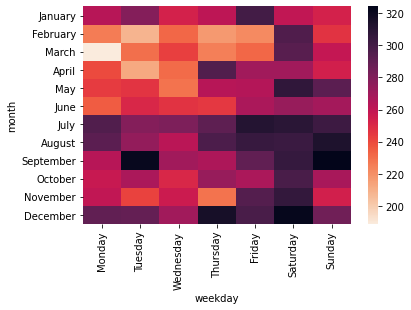

In [ ]:
#group and count per day

police_deaths_grouped = police_deaths.groupby('month')['weekday'].value_counts().to_frame(name='deaths').reset_index()

#Sort by Month

months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']
police_deaths_grouped['month'] = pd.Categorical(police_deaths_grouped['month'], categories=months, ordered=True)

#Sort by Weekday

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

police_deaths_grouped['weekday'] = pd.Categorical(police_deaths_grouped['weekday'], categories=weekdays, ordered=True)

police_deaths_grouped.sort_values(by=['month','weekday'],inplace=True)

# police_deaths_grouped

pol_pivot = police_deaths_grouped.pivot('month','weekday', 'deaths')


sns.heatmap(pol_pivot,
            fmt='.1f',
            annot_kws={'size':10},
            square=False,
            cmap = 'rocket_r')

**The above heatmap shows the fatalities by days per month. The darker areas represent more, and lighter areas means less.**

**As can be seen, Monday of March tends to be the safest day of the year in terms of reduced police deaths.**

## **Exploration 5:**
### Animated Choropleth Map, showing deaths over time

https://towardsdatascience.com/how-to-make-an-animated-gif-map-in-python-using-folium-and-imageio-91d3fc60d084

Ideas: 

- Join Weather/Average Temperature? - Do certain deaths happen more/less often under certain conditions?
- Impacts on inflation/monetary policies? - Do certain economic factors lead to more violent crimes, accidents etc?
- Join crime rate. See how close they correlate 
- look into causation != correlation, how do these factors relate if at all